In [29]:
#pip install tensorflow opencv-python matplotlib

# Brain Tumor Classification
## Introduction


In [30]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading Data
- Data loading from specified paths.
- Creation datasets objects
- Labels convertion to one-hot vectors
- Dataset division into batches

In [31]:
data_train = tf.keras.utils.image_dataset_from_directory(
    '../data_with_description/Brain_Tumor_MRI_Dataset/Training',
    batch_size=32,
    label_mode='categorical'
)

data_test = tf.keras.utils.image_dataset_from_directory(
    '../data_with_description/Brain_Tumor_MRI_Dataset/Testing',
    batch_size=32,
    label_mode='categorical'
)


Found 5712 files belonging to 4 classes.
Found 1316 files belonging to 4 classes.


In [32]:
data_train_iterator = data_train.as_numpy_iterator()
data_test_iterator = data_test.as_numpy_iterator()

In [33]:
batch = data_train_iterator.next()

## Data visualization
- Showing some samples of images

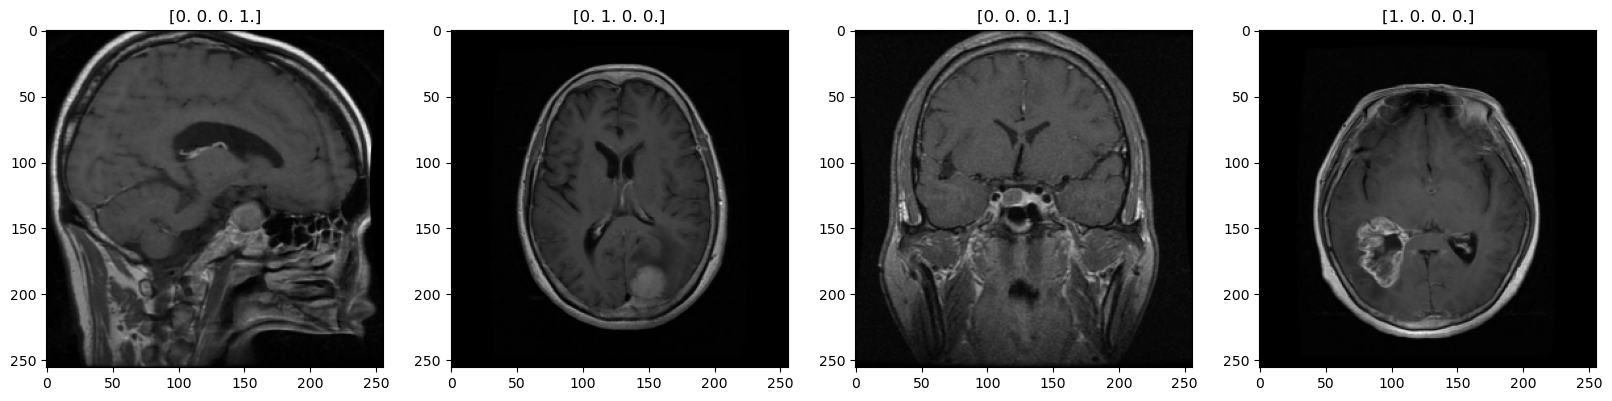

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

0 - glioma
1 - meningioma
2 - no tumor
3 - pituitary

## Preprocesising data
- Resizing images
- Normalization

In [35]:
from tensorflow.image import resize

def preprocess_image(image, target_size=(128, 128)):
    image = resize(image, target_size)
    image = image / 255.0
    return image

In [36]:
data_train = data_train.map(lambda x, y: (preprocess_image(x), y))
data_test = data_test.map(lambda x, y: (preprocess_image(x), y))

In [37]:
batch_train_iterator = data_train.as_numpy_iterator()
batch_test_iterator = data_test.as_numpy_iterator()

In [38]:
batch_train = data_train_iterator.next()
batch_test = data_test_iterator.next()

## Spliting Data
- Training subset: 80% of training dataset
- Validation subset: 20% of training dataset
- Test subset: 100% of testing dataset

In [39]:
validation_split = 0.2

train_and_val = data_train.shuffle(buffer_size=len(data_train))

train_size = int((1 - validation_split) * len(data_train))
val_size = len(data_train) - train_size
test_size = len(data_test)

print('train_size= ' + str(train_size) + ' val_size= ' + str(val_size) + ' test_size= ' + str(test_size))

train_size= 143 val_size= 36 test_size= 42


In [40]:
train = data_train.take(train_size)
val = data_train.skip(train_size).take(val_size)
test = data_test.take(test_size)

## Building model

**InceptionV3** is a deep convolutional neural network architecture that was developed by Google researchers as part of the Inception series, designed to improve the efficiency and accuracy of image classification tasks.

- Applying "transfer learning"with **InceptionV3** as the base model
- **GlobalAveragePooling2D**: Reduces dimensionality by averaging the feature maps into a 1D vector, summarizing the image information.
- **BatchNormalization**: Normalizes activations to stabilize training, improve efficiency, and reduce overfitting.
- **Dense**: Fully connected layers that refine learned features with ReLU activation, and use kernel regularization to prevent overfitting.
- **Classification**: Classifies the image into one of the classes using a Softmax activation function, providing probability distribution over the classes.

In [41]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

In [42]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_94 (Conv2D)            │ (None, 63, 63, 32)        │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_96        │ (None, 63, 63, 32)        │              96 │ conv2d_94[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_94 (Activation)    │ (None, 63, 63, 32)        │               0 │ batch_normalization_96[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_95 (Conv2D)            │ (None, 61, 61, 32)        │           9,216 │ activation_94[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_97        │ (None, 61, 61, 32)        │              96 │ conv2d_95[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_95 (Activation)    │ (None, 61, 61, 32)        │               0 │ batch_normalization_97[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_96 (Conv2D)            │ (None, 61, 61, 64)        │          18,432 │ activation_95[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_98        │ (None, 61, 61, 64)        │             192 │ conv2d_96[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_96 (Activation)    │ (None, 61, 61, 64)        │               0 │ batch_normalization_98[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 30, 30, 64)        │               0 │ activation_96[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_97 (Conv2D)            │ (None, 30, 30, 80)        │           5,120 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_99        │ (None, 30, 30, 80)        │             240 │ conv2d_97[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_97 (Activation)    │ (None, 30, 30, 80)        │               0 │ batch_normalization_99[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_98 (Conv2D)            │ (None, 28, 28, 192)       │         138,24

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [43]:
model = Sequential()

model.add(base_model)
model.add(GlobalMaxPooling2D())


model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_190              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_191              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,353,252 (85.27 MB)

 Trainable params: 22,314,212 (85.12 MB)

 Non-trainable params: 39,040 (152.50 KB)

### Simple graph of the model
Below is a visualization of an architecture of the model:

![Brain Tumor MRI](./model_graph.png)

In [45]:
metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=metrics)

In [47]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)

In [48]:
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

## Model Training

In [49]:
history = model.fit(train, epochs=30, validation_data=val, callbacks=[early_stopping, checkpoint])

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.3697 - loss: 2.3451 - precision: 0.3899 - recall: 0.2992 - val_accuracy: 0.6963 - val_loss: 1.3684 - val_precision: 0.7332 - val_recall: 0.6144
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7288 - loss: 1.2864 - precision: 0.7694 - recall: 0.6722 - val_accuracy: 0.8627 - val_loss: 0.9660 - val_precision: 0.8752 - val_recall: 0.8336
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8454 - loss: 0.9960 - precision: 0.8731 - recall: 0.8157 - val_accuracy: 0.8988 - val_loss: 0.8246 - val_precision: 0.9125 - val_recall: 0.8812
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8957 - loss: 0.8536 - precision: 0.9126 - recall: 0.8740 - val_accuracy: 0.9305 - val_loss: 0.7773 - val_precision: 0.9334 - val_recall: 0.9252
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9337 - loss: 0.7496 - precision: 0.9470 - recall: 0.9223 - val_accuracy: 0.9489 - val_los

In [50]:
model.load_weights('best_model.keras')

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

## Results and Analysis

Below there are plots of each metrics monitored during training:

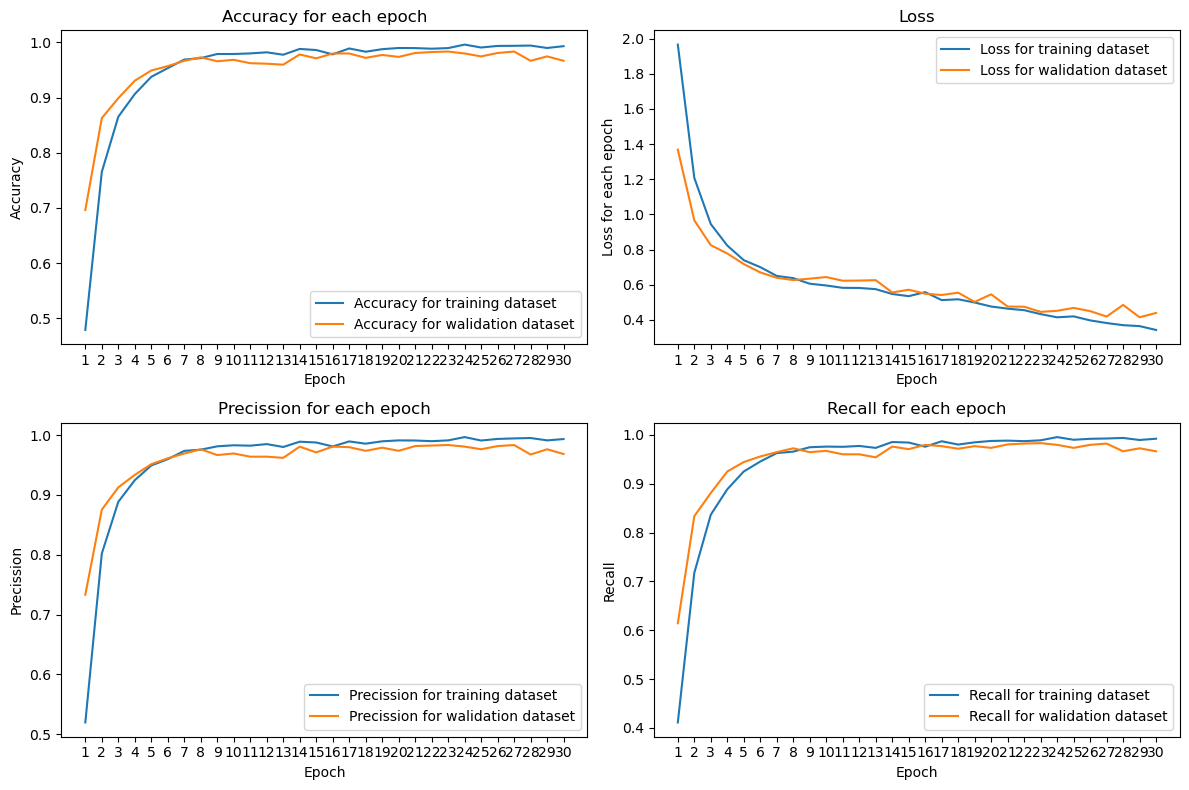

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

epochs = range(1, len(accuracy) + 1)

axes[0, 0].plot(epochs, accuracy, label='Accuracy for training dataset')
axes[0, 0].plot(epochs, val_accuracy, label='Accuracy for walidation dataset')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy for each epoch')
axes[0, 0].legend()
axes[0, 0].set_xticks(epochs)

axes[0, 1].plot(epochs, loss, label='Loss for training dataset')
axes[0, 1].plot(epochs, val_loss, label='Loss for walidation dataset')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss for each epoch')
axes[0, 1].set_title('Loss')
axes[0, 1].legend()
axes[0, 1].set_xticks(epochs)

axes[1, 0].plot(epochs, precision, label='Precission for training dataset')
axes[1, 0].plot(epochs, val_precision, label='Precission for walidation dataset')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precission')
axes[1, 0].set_title('Precission for each epoch')
axes[1, 0].legend()
axes[1, 0].set_xticks(epochs)

axes[1, 1].plot(epochs, recall, label='Recall for training dataset')
axes[1, 1].plot(epochs, val_recall, label='Recall for walidation dataset')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall for each epoch')
axes[1, 1].legend()
axes[1, 1].set_xticks(epochs)

plt.tight_layout()
plt.show()

**Confusion Matrix**

The best way to interpret a confusion matrix is to analyze the values along the diagonal, which represent correct classifications, and compare them to the off-diagonal values, which indicate misclassifications. This helps assess model performance for each class and identify areas for improvement.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

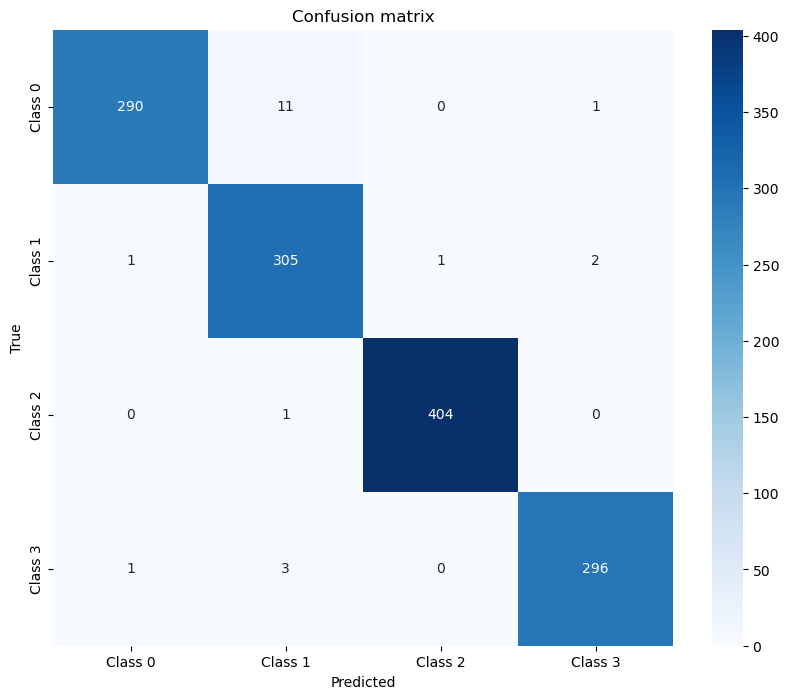

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.98       302
     Class 1       0.95      0.99      0.97       309
     Class 2       1.00      1.00      1.00       405
     Class 3       0.99      0.99      0.99       300

    accuracy                           0.98      1316
   macro avg       0.98      0.98      0.98      1316
weighted avg       0.98      0.98      0.98      1316



In [53]:
y_true = []
y_pred = []

for images, labels in test:
    predictions = model.predict(images)

    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='macro')

print(f"Dokładność (Accuracy): {accuracy:.4f}")
print(f"Precyzja (Precision): {precision:.4f}")
print(f"Czułość (Recall): {recall:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2", "Class 3"]))